## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hanninga (`np.hanning`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:

        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# Load required files
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificate


In [2]:
I_lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)    

In [3]:
def fourier(obraz):
    obraz = obraz.astype("float32")
    F_fourier = cv2.dft(obraz,flags=cv2.DFT_COMPLEX_OUTPUT)
    F_fourier = np.fft.fftshift(F_fourier, [0,1])
    amplituda, faza = cv2.cartToPolar(F_fourier[:,:,0], F_fourier[:,:,1])
    amplituda_log = np.log10(amplituda+1)
    
    return F_fourier, amplituda_log, faza

In [4]:
def odwrotna(F_obraz):
    przesuniecie = np.fft.ifftshift(F_obraz, [0,1]) #odwrotne przesuniecie
    ifft = cv2.idft(przesuniecie, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)#odwrotna transformata
    img_IFFT = cv2.magnitude(ifft[:, :, 0], ifft[:, :, 1])#amplituda
    wynik_odwr= np.round(img_IFFT).astype('uint8')#zaokrąglenie
    return wynik_odwr

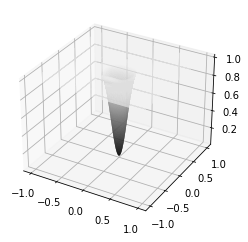

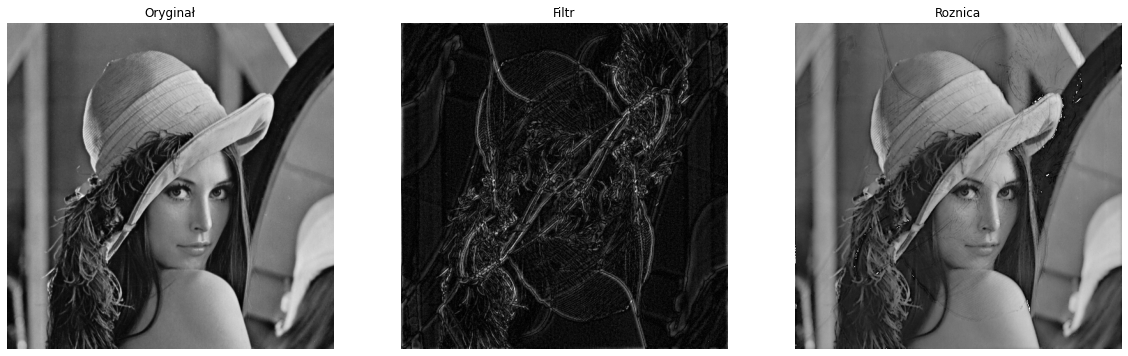

In [5]:
#1 zdefiniowanie rozmiaru filtra
rozmiar_filtra = 21

#2 Okno Hanninga
hanning=np.hanning(rozmiar_filtra)

#3 Okno dwuwymiarowe
hanning2d = np.outer(hanning, hanning)

#3 Stworzenie idealnego filtru wzorcowego
f_Fourier_lena,amplituda_lena,faza_lena=fourier(I_lena)
okno = [rozmiar_filtra,rozmiar_filtra]

#Wygenerowanie macierzy opisujących przestrzenie w dziedzinie częstotliwości
FSpaceRows = 2*np.fft.fftshift(np.fft.fftfreq(okno[0]))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, okno[1]]))
FSpaceCols = 2*np.fft.fftshift(np.fft.fftfreq(okno[1]))
FSpaceColsM = np.outer(np.ones([1, okno[0]]), FSpaceCols) 

#Wyznaczenie macierzy zawierającej "odległość" od składowej stałej.
FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

#Interesujący nas zakres
FilterF = FreqR >= 0.15

#5 Dodatkowe rotacje i przesunięcia
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3),flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

#6 Wymnożenie dwuwymiarowego okna ze stworzonym filtrem idealnym w dziedzinie przestrzennej
Filtr_1 =hanning2d*FilterFI

#7 Przeniesienie do dziedziny częstotliwości
Filtr_2 = cv2.copyMakeBorder(Filtr_1,246,245,246,245,cv2.BORDER_CONSTANT,value=0)

#Obilczenie transformaty Fouriera
Filtr_2 = Filtr_2.astype("float32")
Filtr_3 = cv2.dft(Filtr_2,flags=cv2.DFT_COMPLEX_OUTPUT)

#Wykonanie przesunięcia
Filtr_3 = np.fft.fftshift(Filtr_3, [0,1])

#Obliczenie wartości bezwględnej
Filtr_4 = np.abs(Filtr_3)

#8 Wygenerowanie macierzy opisujących przestrzenie w dziedzinie częstotliwości dla Leny
lenaSize=I_lena.shape
FSpaceRows_1 = 2*np.fft.fftshift(np.fft.fftfreq(lenaSize[0]))
FSpaceRowsM_1 = np.outer(FSpaceRows_1, np.ones([1, lenaSize[1]]))
FSpaceCols_1 = 2*np.fft.fftshift(np.fft.fftfreq(lenaSize[1]))
FSpaceColsM_1 = np.outer(np.ones([1, lenaSize[0]]), FSpaceCols_1)  

#Wizualizacja filtru
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM_1, FSpaceColsM_1, Filtr_4[:,:,0], rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)



Lena_filtr = f_Fourier_lena*Filtr_4

Lena_filtr_2 = odwrotna(Lena_filtr)
roznica = np.abs(I_lena-Lena_filtr_2)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))
ax1.imshow(I_lena, 'gray')
ax1.axis('off')
ax1.set_title('Oryginał')
ax2.imshow(Lena_filtr_2, 'gray')
ax2.axis('off')
ax2.set_title('Filtr')
ax3.imshow(roznica, 'gray')
ax3.axis('off')
ax3.set_title('Roznica')

plt.show()


